## 소프트 맥수 함수 회귀(Softmax Regression)

### 비용 함수(Cost function)

- 크로스 엔트로피 함수
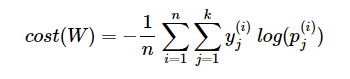
이 값을 최소화하는 방향으로 학습해야 한다.

- 이진 분류에서의 크로스 엔트로피 함수
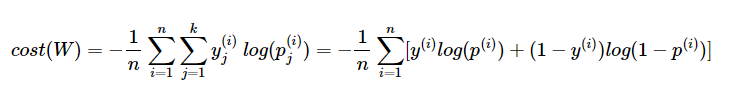

### 소프트맥스 회귀의 비용 함수 구현하기

In [4]:
import torch
import torch.nn.functional as F
torch.manual_seed(1)

#### 파이토치로 소프트맥스의 비용 함수 구현하기 (로우-레벨)

In [5]:
z = torch.FloatTensor([1, 2, 3])

In [9]:
hypothesis = F.softmax(z, dim=0)
print(hypothesis)
#3개의 값모두 0과1사이의 값을 가지는 벡터로 변환된 것을 볼 수 있다.

tensor([0.0900, 0.2447, 0.6652])


In [10]:
hypothesis.sum() #원소의 합 역시 1임을 확인

tensor(1.)

In [11]:
#임의의 3 * 5 행렬의 크기를 가진 텐서를 만든다.
z = torch.rand(3, 5, requires_grad = True)

In [13]:
hypothesis = F.softmax(z, dim = 1)
print(hypothesis)

tensor([[0.2645, 0.1639, 0.1855, 0.2585, 0.1277],
        [0.2430, 0.1624, 0.2322, 0.1930, 0.1694],
        [0.2226, 0.1986, 0.2326, 0.1594, 0.1868]], grad_fn=<SoftmaxBackward>)


In [15]:
y = torch.randint(5, (3,)).long()
print(y)

tensor([0, 2, 1])


In [16]:
#모든 원소가 0의 값을 가진 3 * 5  텐서 생성
y_one_hot = torch.zeros_like(hypothesis) # 모든 원소가 0인 3 * 5 텐서 생성
y_one_hot.scatter_(1,y.unsqueeze(1), 1)
#첫번째 인자로 dim=1에 대해서 수행
#세번째 인자로 1을 넣음으로 두번째 인자의 y_unsqueeze(1)의 위치에 1을 넣음
#_를 붙임으로써 덮어쓰기 연산이 수행된다.

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [19]:
print(y.unsqueeze(1)) # (3,)의 크기를 가졌던 y텐서는 (3 * 1)텐서로 변경

tensor([[0],
        [2],
        [1]])


In [21]:
print(y_one_hot) # 0, 2, 1 위체 1이 출력됨을 알 수 있다.

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.]])


- 소프트맥스 회귀의 비용 함수
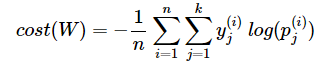
마이너스 부호를 뒤로 빼면 다음 식과 동일합니다.
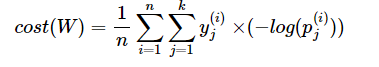

In [24]:
cost = (y_one_hot *  -torch.log(hypothesis)).sum(dim=1).mean()
print(cost)

tensor(1.4689, grad_fn=<MeanBackward0>)


#### 파이토치로 소프트맥스의 비용 함수 구현하기 (하이-레벨)
- F.softmax() + torch.log() = F.log_softmax()

In [26]:
#Low level
torch.log(F.softmax(z, dim=1))

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]], grad_fn=<LogBackward>)

In [27]:
#파이토치는 두 개의 함수를 결합한 F.log_softmax()라는 도구를 제공
#High level
F.log_softmax(z, dim = 1)

tensor([[-1.3301, -1.8084, -1.6846, -1.3530, -2.0584],
        [-1.4147, -1.8174, -1.4602, -1.6450, -1.7758],
        [-1.5025, -1.6165, -1.4586, -1.8360, -1.6776]],
       grad_fn=<LogSoftmaxBackward>)

#### 비용함수 구현
- F.log_softmax() + F.nll_loss() = F.cross_entropy()

In [29]:
#Low level
#첫번쨰 수식
(y_one_hot * -torch.log(F.softmax(z, dim=1))).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [31]:
#두번쨰 수식
(y_one_hot * - F.log_softmax(z, dim=1)).sum(dim=1).mean()

tensor(1.4689, grad_fn=<MeanBackward0>)

In [32]:
#High level
#세번째 수식
#nll_loss : Negative Logt Likelihood의 약자임.
F.nll_loss(F.log_softmax(z, dim =1),y)

tensor(1.4689, grad_fn=<NllLossBackward>)

In [35]:
#네번째 수식
# F.cross_entropy()는 F.log_softmax()와 F.nll_loss()를 포함하고 있습니다.
F.cross_entropy(z, y) #비용함수에 소프트맥수 함수까지 포함되어 있음을 기억하자!

tensor(1.4689, grad_fn=<NllLossBackward>)

## 소프트맥스 회귀 구현하기

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [39]:
x_train = [[1, 2, 1, 1],
           [2, 1, 3, 2],
           [3, 1, 3, 4],
           [4, 1, 5, 5],
           [1, 7, 5, 5],
           [1, 2, 5, 6],
           [1, 6, 6, 6],
           [1, 7, 7, 7]]
y_train = [2, 2, 2, 1, 1, 1, 0, 0]
x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)

#### 소프트맥스 회귀 구현하기(로우-레벨)

In [43]:
#크기
print(x_train.shape)
print(y_train.shape)

torch.Size([8, 4])
torch.Size([8])


In [45]:
#최종 레이블은 y_train에서 원-핫 인코딩을 한 결과여야 한다.
y_one_hot = torch.zeros(8,3)
y_one_hot.scatter_(1, y_train.unsqueeze(1), 1)
print(y_one_hot)

tensor([[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


In [53]:
#레이블의 크기가 8 * 3이므로 X * W = Y, 이므로
# W의 크기는 4 * 3 이여야 한다.

#모델 초기화
W = torch.zeros((4,3), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

#optimizer 설정
optimizer = optim.SGD([W, b], lr = 0.1)

In [57]:
nb_epochs = 1000
for epoch in range(nb_epochs+1):
    
    #가설
    hypothesis = F.softmax(x_train.matmul(W) + b, dim=1)
    
    #비용 함수
    cost = (y_one_hot * -torch.log(hypothesis)).sum(dim=1).mean()
    
    #cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.032775
Epoch  100/1000 Cost: 0.712104
Epoch  200/1000 Cost: 0.637315
Epoch  300/1000 Cost: 0.590370
Epoch  400/1000 Cost: 0.553425
Epoch  500/1000 Cost: 0.521420
Epoch  600/1000 Cost: 0.492227
Epoch  700/1000 Cost: 0.464692
Epoch  800/1000 Cost: 0.438060
Epoch  900/1000 Cost: 0.411747
Epoch 1000/1000 Cost: 0.385264


#### 소프트맥스 회귀 구현하기(하이-레벨)

In [62]:
# 모델 초기화
W = torch.zeros((4, 3), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
# optimizer 설정
optimizer = optim.SGD([W, b], lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # Cost 계산
    z = x_train.matmul(W) + b
    cost = F.cross_entropy(z, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 100번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.098612
Epoch  100/1000 Cost: 0.761050
Epoch  200/1000 Cost: 0.689991
Epoch  300/1000 Cost: 0.643229
Epoch  400/1000 Cost: 0.604117
Epoch  500/1000 Cost: 0.568255
Epoch  600/1000 Cost: 0.533922
Epoch  700/1000 Cost: 0.500291
Epoch  800/1000 Cost: 0.466908
Epoch  900/1000 Cost: 0.433507
Epoch 1000/1000 Cost: 0.399962


#### 소프트맥스 회귀 nn.module로 구현하기

In [64]:
# 모델을 선언 및 초기화. 4개의 특성을 가지고 3개의 클래스로 분류. input_dim=4, output_dim=3.
model = nn.Linear(4, 3)

In [67]:
# optimizer 설정
optimizer = optim.SGD(model.parameters(), lr=0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):

    # H(x) 계산
    prediction = model(x_train)

    # cost 계산
    cost = F.cross_entropy(prediction, y_train)

    # cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 0.254477
Epoch  100/1000 Cost: 0.234852
Epoch  200/1000 Cost: 0.223383
Epoch  300/1000 Cost: 0.212954
Epoch  400/1000 Cost: 0.203418
Epoch  500/1000 Cost: 0.194667
Epoch  600/1000 Cost: 0.186609
Epoch  700/1000 Cost: 0.179166
Epoch  800/1000 Cost: 0.172271
Epoch  900/1000 Cost: 0.165868
Epoch 1000/1000 Cost: 0.159906


####소프트맥스 회귀 클래스로 구현하기

In [75]:
class SoftmaxClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,3) # ouput이 3개이다.
        
    def forward(self,x):
        return self.linear(x)

In [76]:
model = SoftmaxClassifierModel()

In [77]:
#optimizer 설정
optimizer = optim.SGD(model.parameters(), lr = 0.1)

nb_epochs = 1000
for epoch in range(nb_epochs + 1):
    
    #H(x) 계산
    prediction = model(x_train)
    
    #cost 계산
    cost = F.cross_entropy(prediction, y_train)
    
    #cost로 H(x) 개선
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 20번마다 로그 출력
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))

Epoch    0/1000 Cost: 1.366217
Epoch  100/1000 Cost: 0.722726
Epoch  200/1000 Cost: 0.637564
Epoch  300/1000 Cost: 0.578576
Epoch  400/1000 Cost: 0.527363
Epoch  500/1000 Cost: 0.479316
Epoch  600/1000 Cost: 0.432700
Epoch  700/1000 Cost: 0.386693
Epoch  800/1000 Cost: 0.340930
Epoch  900/1000 Cost: 0.295757
Epoch 1000/1000 Cost: 0.255350
